<div class="description user_content student-version enhanced"><p>The program <span class="instructure_file_holder link_holder"><a class="instructure_file_link" title="main_detect.py" href="/courses/25410/files/2307682/download?wrap=1" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/2307682" data-api-returntype="File">main_detect.py</a></span> detects and matches features between a training image and a query image. It tries to fit an affine transform to the feature matches, using a robust fitting method (least median of squares) to handle outliers (incorrect matches). If it can successfully fit an affine transform, the object is “detected”, and the program warps the training image and blends it with the query image.</p>
<p>Run the program, using the training image “juice.pgm” and the query image “Img03.pgm” (from <a class="instructure_file_link" title="images.zip" href="/courses/25410/files/2307689/download?wrap=1" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/2307689" data-api-returntype="File">images.zip</a>). Verify that the program successfully detects the object in the query image, meaning that the program overlays the object correctly on the blended image.</p>



<h3>Turn in</h3>
<p>The answers to questions 1..5</p></div>

In [10]:
import os
import cv2
import numpy as np
import glob

from IPython.display import display, HTML
import ipywidgets as widgets  # Using the ipython notebook widgets
import IPython

#Use 'jpeg' instead of 'png' (~5 times faster)
import PIL.Image
from io import BytesIO

#Use 'jpeg' instead of 'png' (~5 times faster)
def imdisplay(img, fmt='jpeg',width=500):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_p = PIL.Image.fromarray(img)    
    f = BytesIO()
    if new_p.mode != 'RGB':
        new_p = new_p.convert('RGB')
    new_p.save(f, fmt)
    return IPython.display.Image(data=f.getvalue(), width=width)


from IPython.display import Javascript
def preventScrolling():
    disable_js = """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """
    display(Javascript(disable_js))

preventScrolling()

def main(IMAGE_DIRECTORY, TRAINING_IMAGE_NAME, QUERY_IMAGE_NAME):
    file_path = os.path.join(IMAGE_DIRECTORY, TRAINING_IMAGE_NAME)
    assert (os.path.exists(file_path))
    bgr_train = cv2.imread(file_path)  # Get training image
    file_path = os.path.join(IMAGE_DIRECTORY, QUERY_IMAGE_NAME)
    assert (os.path.exists(file_path))
    bgr_query = cv2.imread(file_path)  # Get query image

    # Show input images.
#     cv2.imshow("Training image", bgr_train)
#     cv2.imshow("Query image", bgr_query)

    # Extract keypoints and descriptors.
    kp_train, desc_train = detect_features(bgr_train, show_features=False)
    kp_query, desc_query = detect_features(bgr_query, show_features=False)

    matcher = cv2.BFMatcher.create(cv2.NORM_L2)

    # Match query image descriptors to the training image.
    # Use k nearest neighbor matching and apply ratio test.
    matches = matcher.knnMatch(desc_query, desc_train, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)
    matches = good
    print("Number of raw matches between training and query: ", len(matches))

#     bgr_matches = cv2.drawMatches(
#         img1 = bgr_query, keypoints1 = kp_query,
#         img2 = bgr_train, keypoints2 = kp_train,
#         matches1to2 = matches, matchesMask = None, outImg = None)
#     cv2.imshow("All matches", bgr_matches)

    # show_votes(bgr_query, kp_query, bgr_train, kp_train, matches)

    matches=find_cluster(bgr_query, kp_query, bgr_train, kp_train, matches,show_votes = False)
    print("Number of matches in the largest cluster:", len(matches))

    # Draw matches between query image and training image.
    bgr_matches=cv2.drawMatches(
        img1 = bgr_query, keypoints1 = kp_query,
        img2 = bgr_train, keypoints2 = kp_train,
        matches1to2 = matches, matchesMask = None, outImg = None)
#     cv2.imshow("Matches in largest cluster", bgr_matches)
    display(imdisplay(bgr_matches.astype(np.uint8), width=900))
    # Calculate an affine transformation from the training image to the query image.
    A_train_query, inliers=calc_affine_transformation(
        matches, kp_train, kp_query)

    # Apply the affine warp to warp the training image to the query image.
    if A_train_query is not None:
        # Object detected! Warp the training image to the query image and blend the images.
        print("Object detected! Found %d inlier matches" % sum(inliers))
        warped_training=cv2.warpAffine(
            src = bgr_train, M = A_train_query,
            dsize = (bgr_query.shape[1], bgr_query.shape[0]))

        # Blend the images.
        blended_image=bgr_query / 2
        blended_image[:, :, 1] += warped_training[:, :, 1] / 2
        blended_image[:, :, 2] += warped_training[:, :, 2] / 2
#         cv2.imshow("Blended", blended_image.astype(np.uint8))
        display(imdisplay(blended_image.astype(np.uint8), width=900))
    else:
        print("Object not detected; can't fit an affine transform")

#     cv2.waitKey(0)
    cv2.destroyAllWindows()

def main_threshold(IMAGE_DIRECTORY, TRAINING_IMAGE_NAME, QUERY_IMAGE_NAME, threshold=5):
    file_path = os.path.join(IMAGE_DIRECTORY, TRAINING_IMAGE_NAME)
    assert (os.path.exists(file_path))
    bgr_train = cv2.imread(file_path)  # Get training image
    file_path = os.path.join(IMAGE_DIRECTORY, QUERY_IMAGE_NAME)
    assert (os.path.exists(file_path))
    bgr_query = cv2.imread(file_path)  # Get query image

    # Show input images.
#     cv2.imshow("Training image", bgr_train)
#     cv2.imshow("Query image", bgr_query)

    # Extract keypoints and descriptors.
    kp_train, desc_train = detect_features(bgr_train, show_features=False)
    kp_query, desc_query = detect_features(bgr_query, show_features=False)

    matcher = cv2.BFMatcher.create(cv2.NORM_L2)

    # Match query image descriptors to the training image.
    # Use k nearest neighbor matching and apply ratio test.
    matches = matcher.knnMatch(desc_query, desc_train, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)
    matches = good
    print("Number of raw matches between training and query: ", len(matches))

    matches=find_cluster(bgr_query, kp_query, bgr_train, kp_train, matches,show_votes = False)
    print("Number of matches in the largest cluster:", len(matches))

    # Draw matches between query image and training image.
    bgr_matches=cv2.drawMatches(
        img1 = bgr_query, keypoints1 = kp_query,
        img2 = bgr_train, keypoints2 = kp_train,
        matches1to2 = matches, matchesMask = None, outImg = None)
#     cv2.imshow("Matches in largest cluster", bgr_matches)
    display(imdisplay(bgr_matches.astype(np.uint8), width=900))
    # Calculate an affine transformation from the training image to the query image.
    A_train_query, inliers=calc_affine_transformation(
        matches, kp_train, kp_query)

    # Apply the affine warp to warp the training image to the query image.
    if A_train_query is not None and sum(inliers) >= threshold:
        # Object detected! Warp the training image to the query image and blend the images.
        print("Object detected! Found %d inlier matches" % sum(inliers))
        warped_training=cv2.warpAffine(
            src = bgr_train, M = A_train_query,
            dsize = (bgr_query.shape[1], bgr_query.shape[0]))

        # Blend the images.
        blended_image=bgr_query / 2
        blended_image[:, :, 1] += warped_training[:, :, 1] / 2
        blended_image[:, :, 2] += warped_training[:, :, 2] / 2
#         cv2.imshow("Blended", blended_image.astype(np.uint8))
        display(imdisplay(blended_image.astype(np.uint8), width=900))

    else:
        print("Object not detected; can't fit an affine transform")

#     cv2.waitKey(0)
    cv2.destroyAllWindows()

# Detect features in the image and return the keypoints and descriptors.
def detect_features(bgr_img, show_features = False):
    detector=cv2.xfeatures2d.SURF_create(
        hessianThreshold = 100,  # default = 100
        nOctaves = 4,  # default = 4
        nOctaveLayers = 3,  # default = 3
        extended = False,  # default = False
        upright = False  # default = False
    )

    # Extract keypoints and descriptors from image.
    gray_image=cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors=detector.detectAndCompute(gray_image, mask = None)

    # Optionally draw detected keypoints.
    if show_features:
        # Possible flags: DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, DRAW_MATCHES_FLAGS_DEFAULT
        bgr_display=bgr_img.copy()
        cv2.drawKeypoints(image = bgr_display, keypoints = keypoints,
                          outImage = bgr_display,
                          flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#         cv2.imshow("Features", bgr_display)
        print("Number of keypoints: ", len(keypoints))
#         cv2.waitKey(0)

    return keypoints, descriptors


# Given the proposed matches, each match votes into a quantized "pose" space. Find the
# bin with the largest number of votes, and return the matches within that bin.
def find_cluster(query_img, keypoints_query, train_img, keypoints_train, matches,show_votes=False):
    hq = query_img.shape[0]
    wq = query_img.shape[1]

    max_scale = 4.0  # Scale differences go from 0 to max_scale

    # Our accumulator array is a 4D array of empty lists. These are the number of bins
    # for each of the dimensions.
    num_bins_height = 5
    num_bins_width = 5
    num_bins_scale = 5
    num_bins_ang = 8

    # It is easier to have a 1 dimensional array instead of a 4 dimensional array.
    # Just convert subscripts (h,w,s,a) to indices idx.
    size_acc = num_bins_height * num_bins_width * num_bins_scale * num_bins_ang
    acc_array = [[] for idx in range(size_acc)]

    ht = train_img.shape[0]
    wt = train_img.shape[1]

    # Vote into accumulator array.
    for match in matches:
        qi = match.queryIdx  # Index of query keypoint
        ti = match.trainIdx  # Index of training keypoint that matched

        # Get data for training image.
        kp_train = keypoints_train[ti]
        at = kp_train.angle
        st = kp_train.size
        pt = np.array(kp_train.pt)  # training keypoint location
        mt = np.array([wt / 2, ht / 2])  # Center of training image
        vt = mt - pt  # Vector from keypoint to center

        # Get data for query image.
        kp_query = keypoints_query[qi]
        aq = kp_query.angle
        sq = kp_query.size
        pq = np.array(kp_query.pt)

        # Rotate and scale the vector to the marker point.
        scale_factor = sq / st
        angle_diff = aq - at
        angle_diff = (angle_diff + 360) % 360  # Force angle to between 0..360 degrees
        vq = rotate_and_scale(vt, scale_factor, angle_diff)
        mq = pq + vq

        if show_votes:
            print("Scale diff %f, angle diff %f" % (scale_factor, angle_diff))

            # Display training image.
            train_img_display = train_img.copy()
            cv2.drawKeypoints(image=train_img_display, keypoints=[kp_train],
                              outImage=train_img_display,
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cv2.drawMarker(img=train_img_display, position=(int(mt[0]), int(mt[1])),color=(255, 0, 0),markerType=cv2.MARKER_DIAMOND)
            cv2.line(img=train_img_display,pt1=(int(pt[0]), int(pt[1])), pt2=(int(mt[0]), int(mt[1])),color=(255, 0, 0), thickness=2)
#             cv2.imshow("Training keypoint", train_img_display)

            # Display query image.
            query_img_display = query_img.copy()
            cv2.drawKeypoints(image=query_img_display, keypoints=[kp_query],
                              outImage=query_img_display,
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cv2.line(img=query_img_display,pt1=(int(pq[0]), int(pq[1])), pt2=(int(mq[0]), int(mq[1])),color=(255, 0, 0), thickness=2)
#             cv2.imshow("Query keypoint", query_img_display)
#             cv2.waitKey(100)

        # Compute the cell of the accumulator array, that this match should be stored in.
        row_subscript = int(round(num_bins_height * (mq[1] / hq)))
        col_subscript = int(round(num_bins_width * (mq[0] / wq)))
        if row_subscript >= 0 and row_subscript < num_bins_height and col_subscript >= 0 and col_subscript < num_bins_width:
            scale_subscript = int(num_bins_scale * (scale_factor / max_scale))
            if scale_subscript > num_bins_scale:
                scale_subscript = num_bins_scale - 1

            ang_subscript = int(num_bins_ang * (angle_diff / 360))
            # print(row_subscript,col_subscript, scale_subscript, ang_subscript)

            # Note: the numpy functions ravel_multi_index(), and unravel_index() convert
            # subscripts to indices, and vice versa.
            idx = np.ravel_multi_index((row_subscript, col_subscript, scale_subscript, ang_subscript),(num_bins_height, num_bins_width, num_bins_scale, num_bins_ang))

            acc_array[idx].append(match)

    # Count matches in each bin.
    counts = [len(acc_array[idx]) for idx in range(size_acc)]

    # Find the bin with maximum number of counts.
    idx_max = np.argmax(np.array(counts))

    # Return the matches in the largest bin.
    return acc_array[idx_max]


# Calculate an affine transformation from the training image to the query image.
def calc_affine_transformation(matches_in_cluster, kp_train, kp_query):
    if len(matches_in_cluster) < 3:
        # Not enough matches to calculate affine transformation.
        return None, None

    # Estimate affine transformation from training to query image points.
    # Use the "least median of squares" method for robustness. It also detects outliers.
    # Outliers are those points that have a large error relative to the median of errors.
    src_pts = np.float32([kp_train[m.trainIdx].pt for m in matches_in_cluster]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_query[m.queryIdx].pt for m in matches_in_cluster]).reshape(-1, 1, 2)
    A_train_query, inliers = cv2.estimateAffine2D(src_pts, dst_pts,method=cv2.LMEDS)

    return A_train_query, inliers


def rotate_and_scale(vt, scale_factor, angle_diff):
    theta = np.radians(angle_diff)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    vq = R @ vt
    vq = vq * scale_factor
    return vq

def displayResults(actual, results):
    
    table = f'''
    <table style="width: 50%; border-collapse: collapse;" border="1">
        <tbody>
            <tr>
                <td style="width: 33.3333%;">Image</td>
                <td style="width: 33.3333%;">Object is really present (y/n)</td>
                <td style="width: 33.3333%;">Program detected the object (y/n)</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg01</td>
                <td style="width: 33.3333%;">{bool(actual[0])}</td>
                <td style="width: 33.3333%;">{bool(results[0])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg02</td>
                <td style="width: 33.3333%;">{bool(actual[1])}</td>
                <td style="width: 33.3333%;">{bool(results[1])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg03</td>
                <td style="width: 33.3333%;">{bool(actual[2])}</td>
                <td style="width: 33.3333%;">{bool(results[2])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg04</td>
                <td style="width: 33.3333%;">{bool(actual[3])}</td>
                <td style="width: 33.3333%;">{bool(results[3])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg05</td>
                <td style="width: 33.3333%;">{bool(actual[4])}</td>
                <td style="width: 33.3333%;">{bool(results[4])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg06</td>
                <td style="width: 33.3333%;">{bool(actual[5])}</td>
                <td style="width: 33.3333%;">{bool(results[5])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg07</td>
                <td style="width: 33.3333%;">{bool(actual[6])}</td>
                <td style="width: 33.3333%;">{bool(results[6])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg08</td>
                <td style="width: 33.3333%;">{bool(actual[7])}</td>
                <td style="width: 33.3333%;">{bool(results[7])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg09</td>
                <td style="width: 33.3333%;">{bool(actual[8])}</td>
                <td style="width: 33.3333%;">{bool(results[8])}</td>
            </tr>
            <tr>
                <td style="width: 33.3333%;">TestImg010</td>
                <td style="width: 33.3333%;">{bool(actual[9])}</td>
                <td style="width: 33.3333%;">{bool(results[9])}</td>
            </tr>
        </tbody>
    </table>
    '''
    display(HTML(table))

<IPython.core.display.Javascript object>

<p>1. How many inlier matches were found?</p>
<p>Run the program, using the training image “juice.pgm” and the query image “Img02.pgm”. In this case, the object is not in the query image, so the program should not be able to detect it. However, the program can still fit an affine transform, but it is incorrect. In other words, this is a “false positive”.</p>



Img03.pgm

Number of raw matches between training and query:  104
Number of matches in the largest cluster: 31


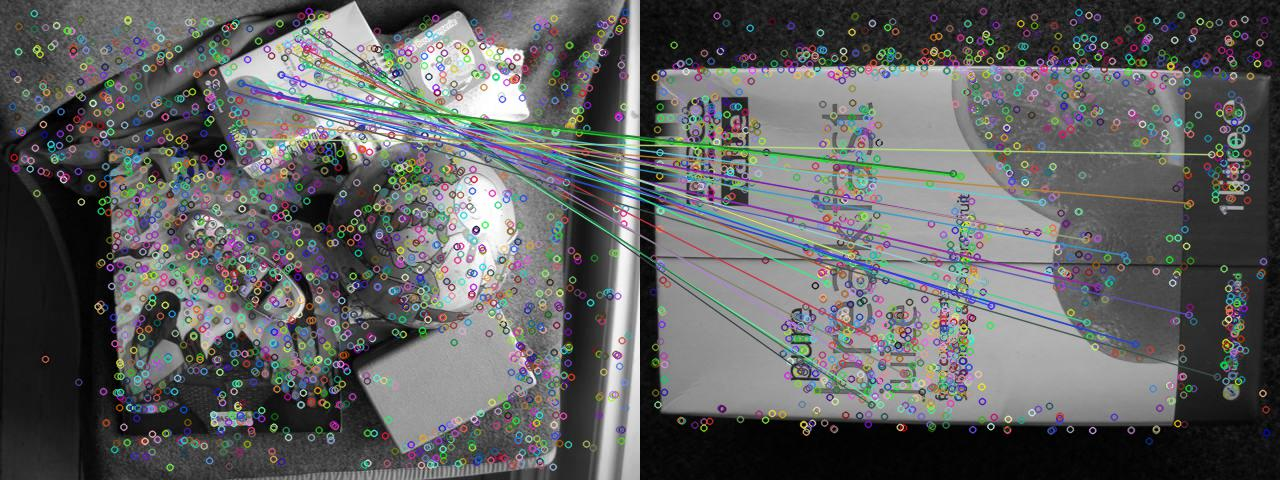

Object detected! Found 29 inlier matches


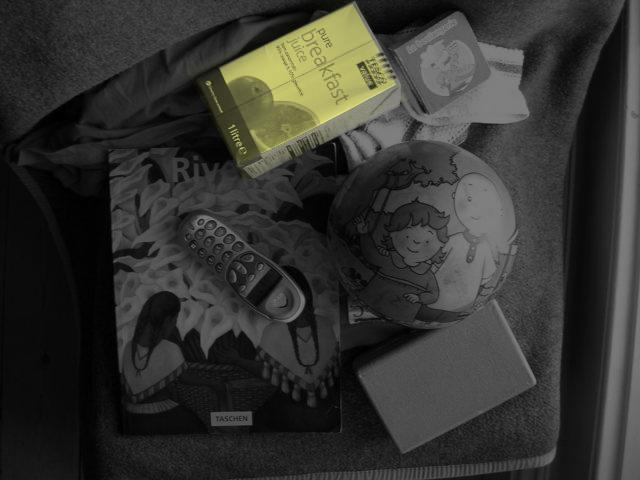



Img02.pgm

Number of raw matches between training and query:  74
Number of matches in the largest cluster: 3


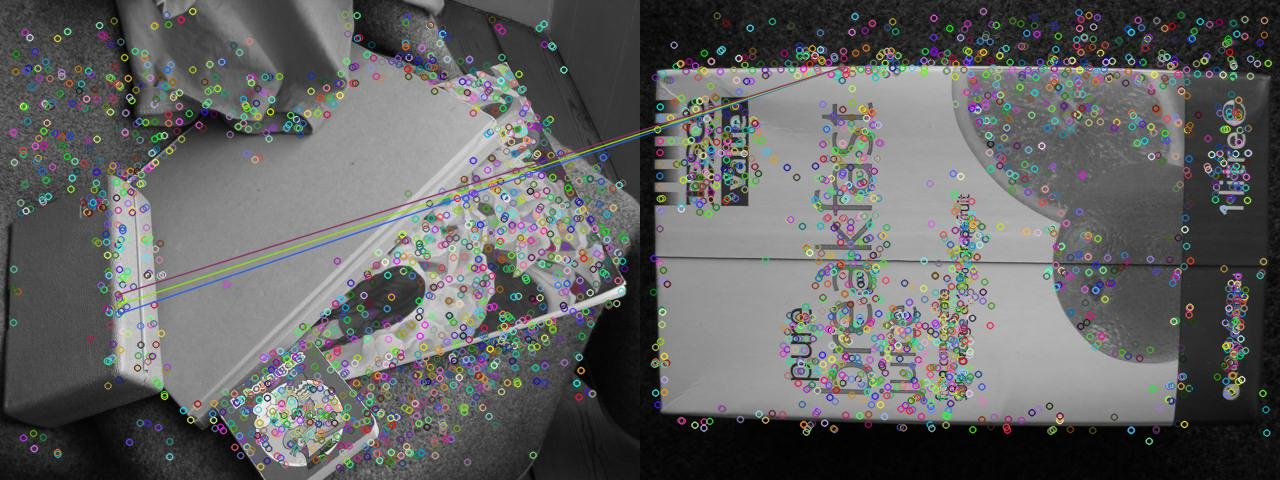

Object detected! Found 3 inlier matches


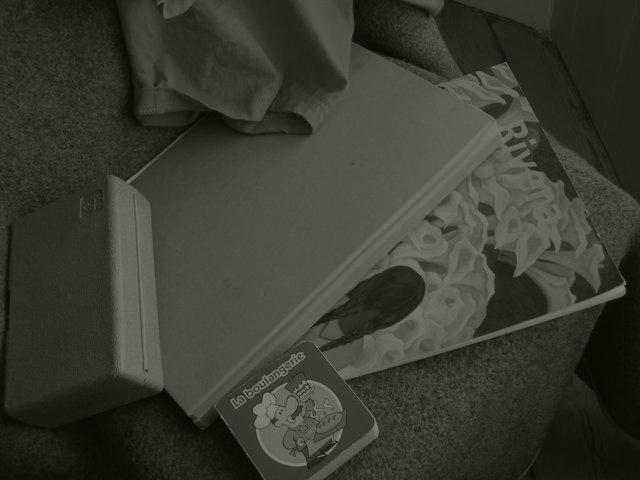

In [11]:
IMAGE_DIRECTORY = "images/pgm"
TRAINING_IMAGE_NAME = "juice.pgm"
QUERY_IMAGE_NAME = "Img03.pgm"
print("\n\nImg03.pgm\n")
main(IMAGE_DIRECTORY,TRAINING_IMAGE_NAME,QUERY_IMAGE_NAME)
QUERY_IMAGE_NAME = "Img02.pgm"
print("\n\nImg02.pgm\n")
main(IMAGE_DIRECTORY,TRAINING_IMAGE_NAME,QUERY_IMAGE_NAME)

<p>2. How many inlier matches were found for this image?</p>
<p>One way to avoid errors like this is to require a larger number of inlier matches, in order to be sure that the affine transform is valid. Add code to count the number of inliers and test to see if it is greater or equal to a minimum threshold number. Use the value of 5 for this threshold. Now verify that the program does not report a detection for this image.</p>



Img02.pgm with Threshold of: 5 

Number of raw matches between training and query:  74
Number of matches in the largest cluster: 3


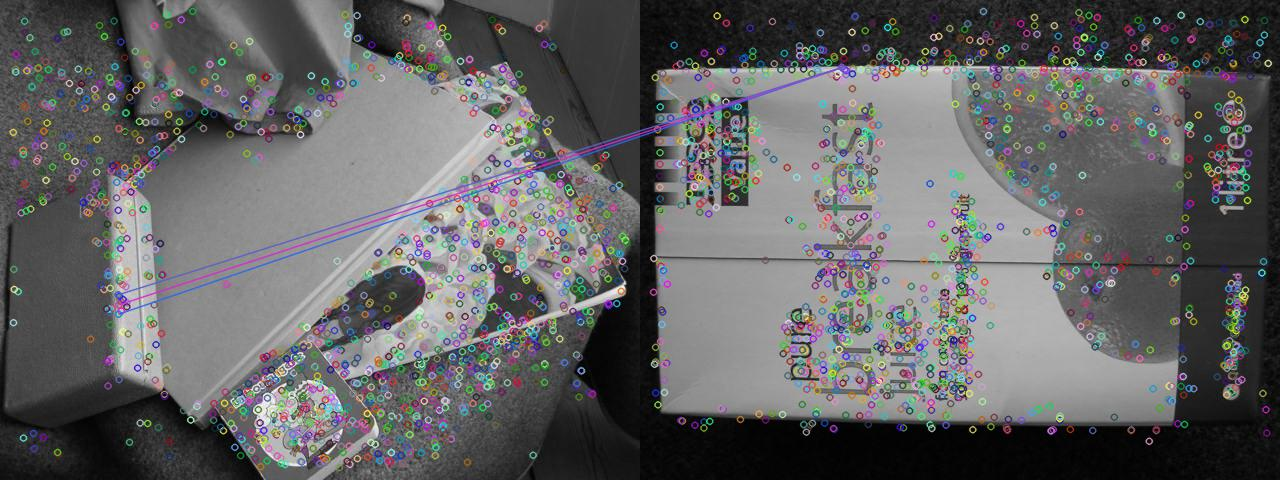

Object not detected; can't fit an affine transform


In [12]:
QUERY_IMAGE_NAME = "Img02.pgm"
threshold = 5
print("\n\nImg02.pgm with Threshold of:", threshold,"\n")
main_threshold(IMAGE_DIRECTORY,TRAINING_IMAGE_NAME,QUERY_IMAGE_NAME, threshold)

<p>In addition to “recall” and “precision”, another commonly used metric is “accuracy”, for characterizing the performance of a classifier or recognition system. Accuracy is just the number of correct assessments divided by the number of all assessments. In other words, count the number of true positives (i.e., the number of times the object was detected and it was really there) and the number of true negatives (i.e., the number of times the object was not detected and it was not really there).</p>
<p>Run the program with the training image “book1.pgm”, on the query images “TestImg01.pgm” through “TestImg010.pgm”. It may help to fill in the following table with YES or NO in each entry. Hint: the object is present in half the images.</p>
<table style="width: 50%; border-collapse: collapse;" border="1">
<tbody>
<tr>
<td style="width: 33.3333%;">Image</td>
<td style="width: 33.3333%;">Object is really present (y/n)</td>
<td style="width: 33.3333%;">Program detected the object (y/n)</td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg01</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg02</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg03</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg04</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg05</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg06</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg07</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg08</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg09</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
<tr>
<td style="width: 33.3333%;">TestImg010</td>
<td style="width: 33.3333%;"></td>
<td style="width: 33.3333%;"></td>
</tr>
</tbody>
</table>
<p>Report the following values:</p>
<p>3. Number of true positives (TP)</p>
<p>4. Number of true negatives (TN)</p>
<p>5. Overall accuracy</p>

In [38]:
import glob
IMAGE_DIRECTORY = "images/png/"
TRAINING_IMAGE_NAME = "book1.png"
images = glob.glob(IMAGE_DIRECTORY+"TestImg*.png")
book_present = [1,1,1,0,1,0,0,0,0,1]
book_results = []
threshold = 5



TestImage1

Number of raw matches between training and query:  88
Number of matches in the largest cluster: 11
PASS:	Object detected and was present in the image! Found 11 inlier matches


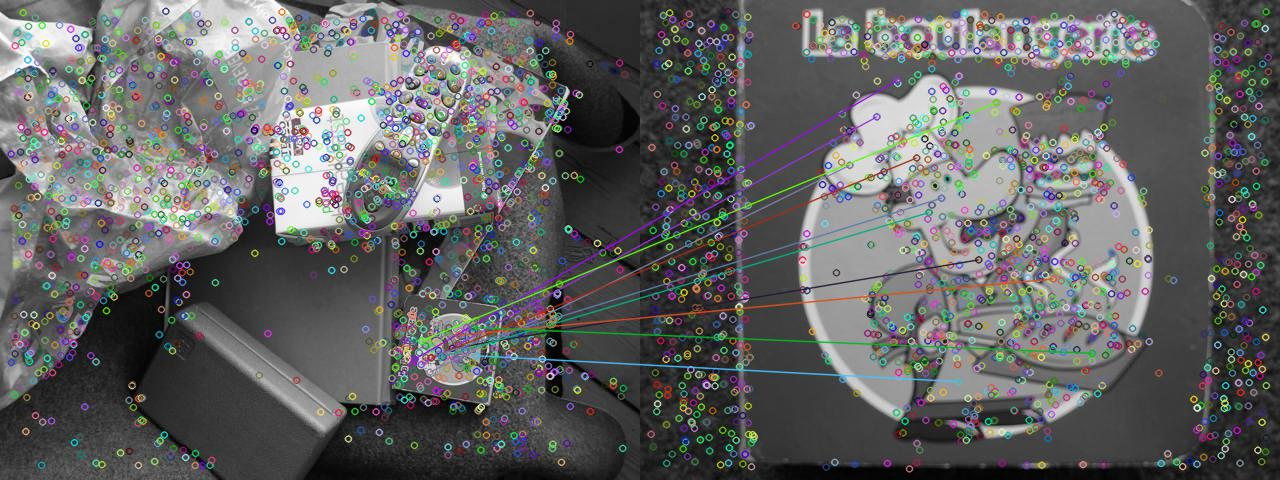

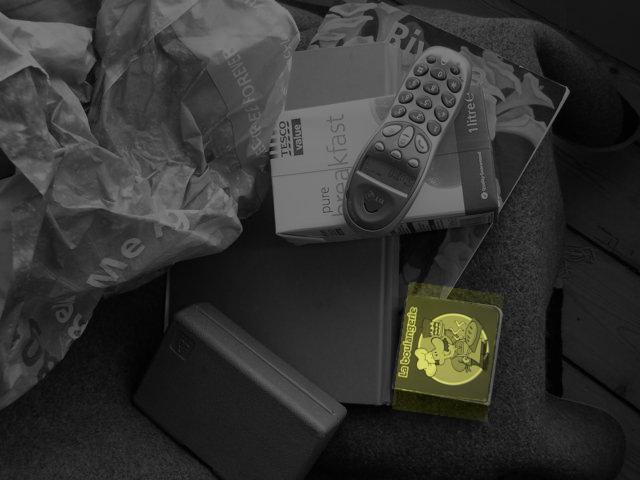

TP:	 11
FP:	 77
Accuracy:	 12.5 %


TestImage2

Number of raw matches between training and query:  88
Number of matches in the largest cluster: 7
PASS:	Object detected and was present in the image! Found 5 inlier matches


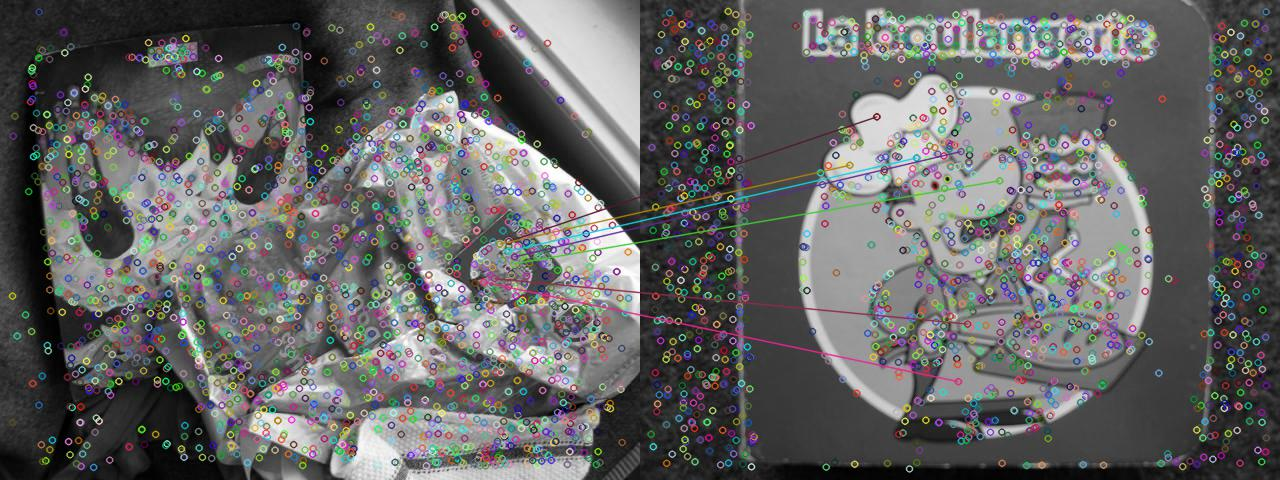

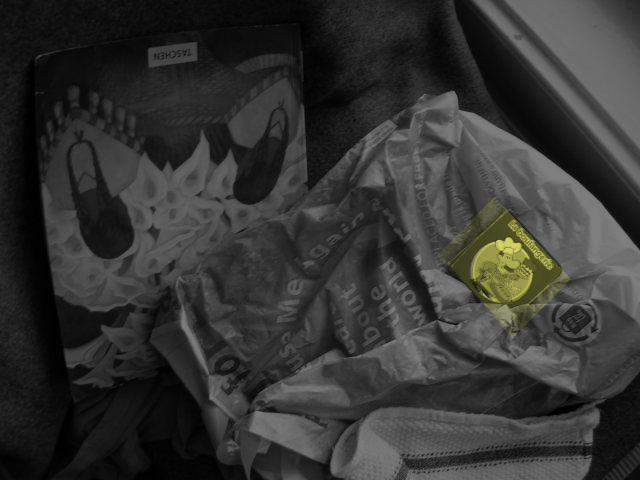

TP:	 7
FP:	 81
Accuracy:	 7.95 %


TestImage3

Number of raw matches between training and query:  92
Number of matches in the largest cluster: 17
PASS:	Object detected and was present in the image! Found 17 inlier matches


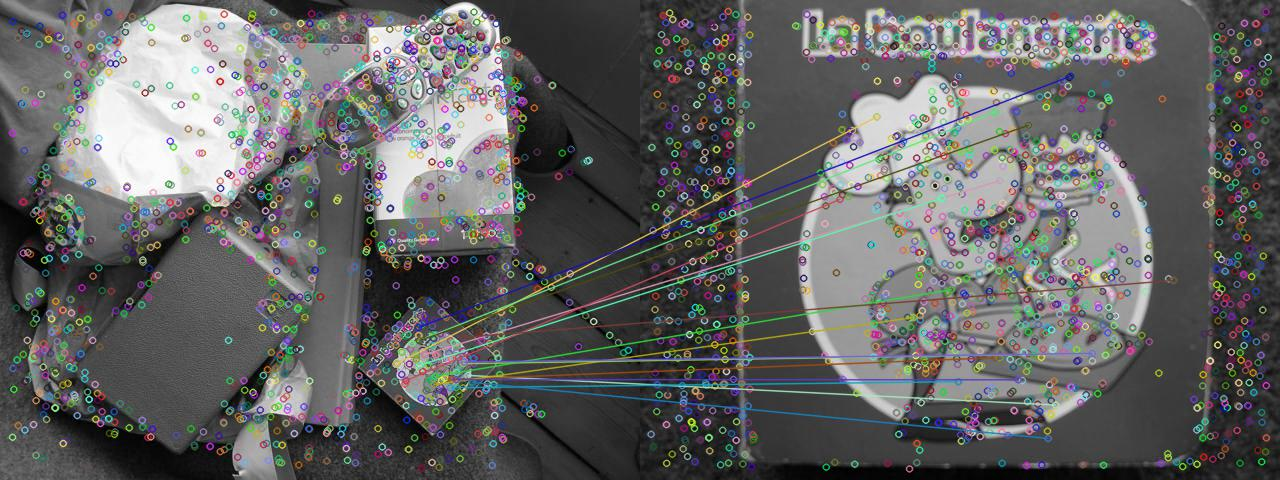

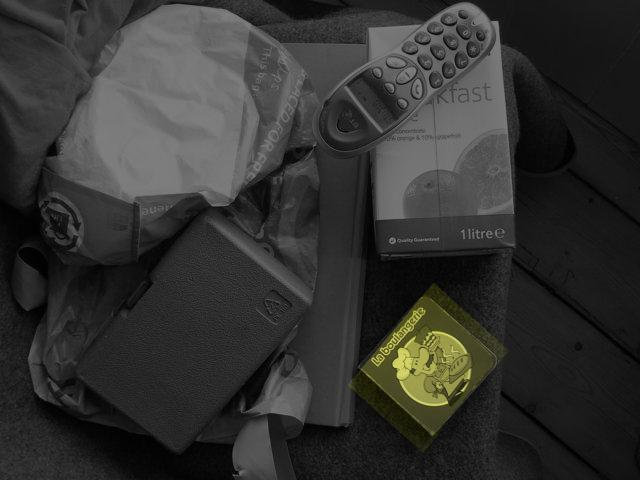

TP:	 17
FP:	 75
Accuracy:	 18.48 %


TestImage4

Number of raw matches between training and query:  89
Number of matches in the largest cluster: 4
Object detected, but removed by an inlier threshold of:  5 with  [3]  inliers
PASS:	Object not detected and was not present in the image; can't fit an affine transform
TP:	 4
FP:	 85
Accuracy:	 4.49 %


TestImage5

Number of raw matches between training and query:  118
Number of matches in the largest cluster: 16
PASS:	Object detected and was present in the image! Found 16 inlier matches


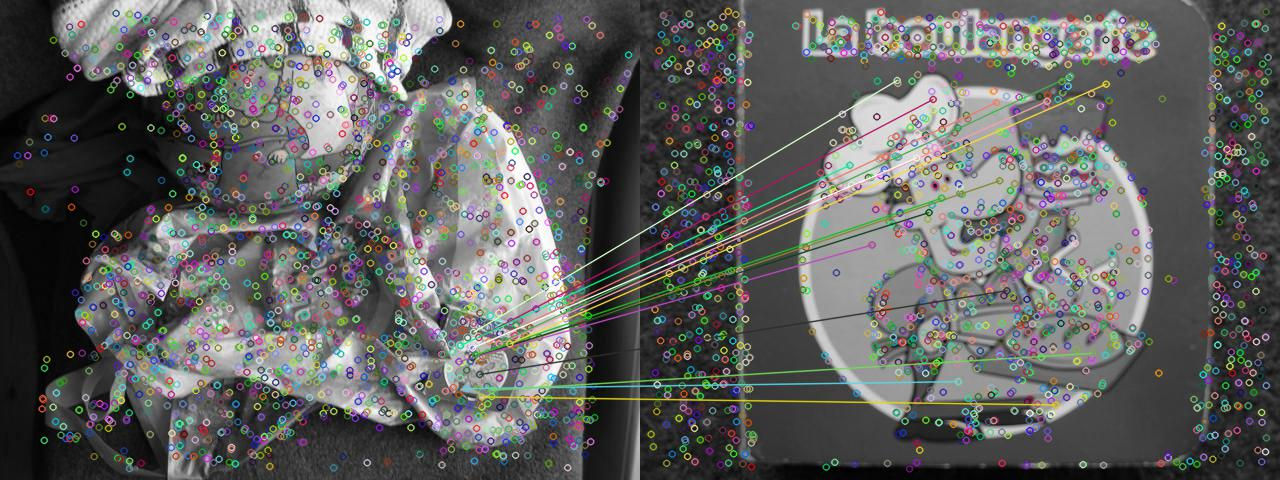

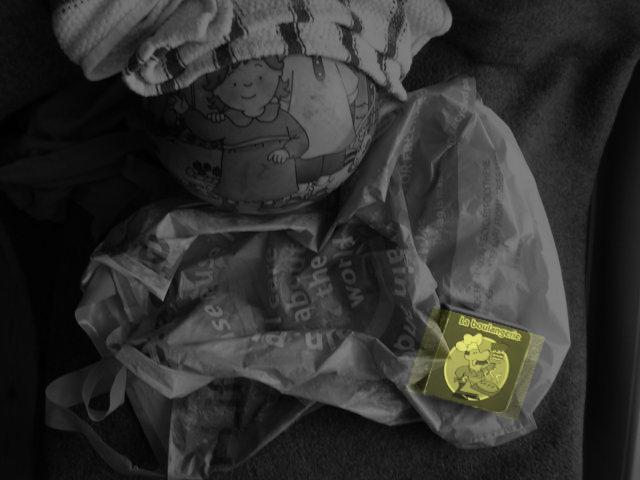

TP:	 16
FP:	 102
Accuracy:	 13.56 %


TestImage6

Number of raw matches between training and query:  91
Number of matches in the largest cluster: 7
FAIL:	Object detected and was NOT in the image! Found 6 inlier matches


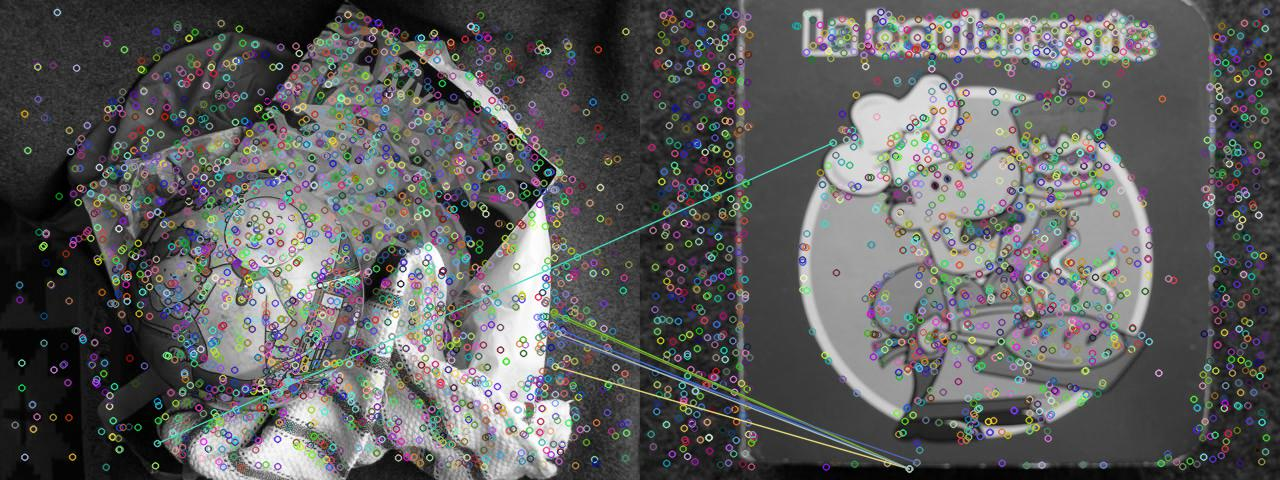

TP:	 7
FP:	 84
Accuracy:	 7.69 %


TestImage7

Number of raw matches between training and query:  92
Number of matches in the largest cluster: 6
PASS:	Object not detected and was not present in the image; can't fit an affine transform
TP:	 6
FP:	 86
Accuracy:	 6.52 %


TestImage8

Number of raw matches between training and query:  66
Number of matches in the largest cluster: 2
PASS:	Object not detected and was not present in the image; can't fit an affine transform
TP:	 2
FP:	 64
Accuracy:	 3.03 %


TestImage9

Number of raw matches between training and query:  56
Number of matches in the largest cluster: 2
PASS:	Object not detected and was not present in the image; can't fit an affine transform
TP:	 2
FP:	 54
Accuracy:	 3.57 %


TestImage10

Number of raw matches between training and query:  105
Number of matches in the largest cluster: 6
FAIL:	Object not detected but WAS present in the image; can't fit an affine transform


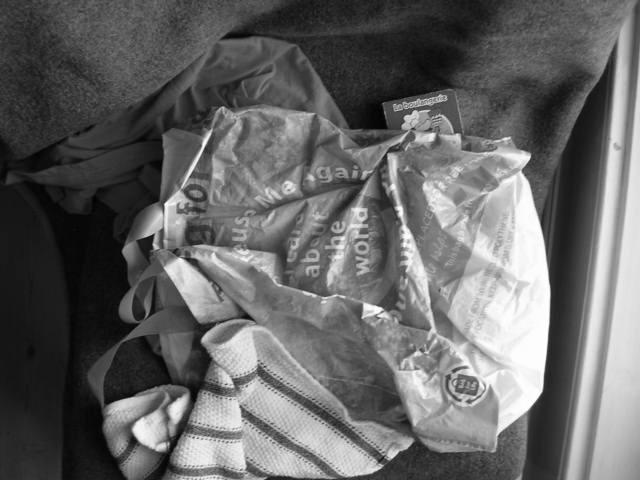

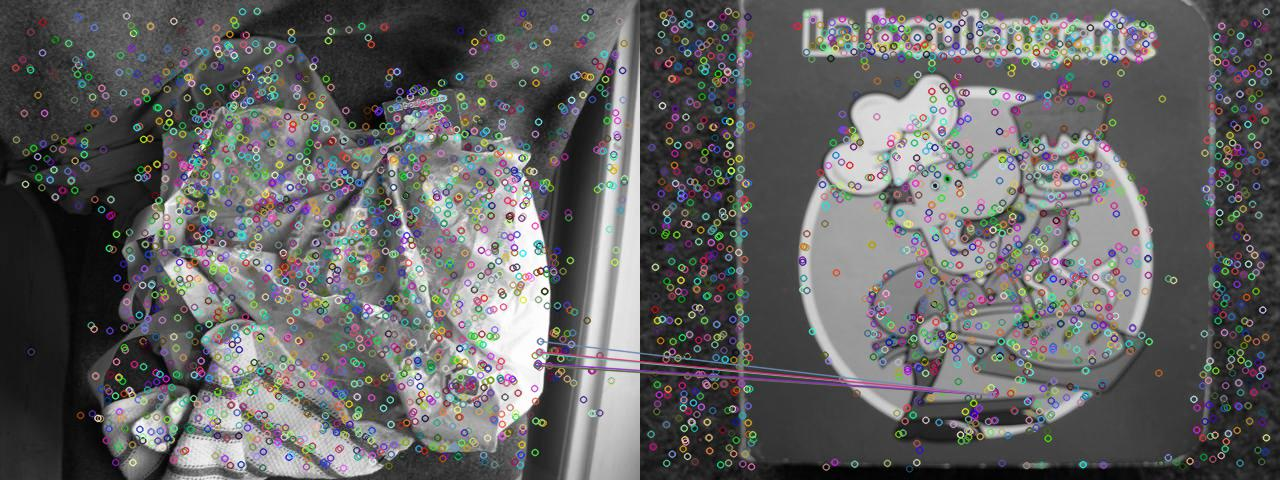

TP:	 6
FP:	 99
Accuracy:	 5.71 %


Image,Object is really present (y/n),Program detected the object (y/n)
TestImg01,True,True
TestImg02,True,True
TestImg03,True,True
TestImg04,False,False
TestImg05,True,True
TestImg06,False,True
TestImg07,False,False
TestImg08,False,False
TestImg09,False,False
TestImg010,True,False


In [39]:
for img_index, image in enumerate(images):
    print("\n\nTestImage"+str(img_index+1)+"\n")
    file_path = os.path.join(IMAGE_DIRECTORY, TRAINING_IMAGE_NAME)
    assert (os.path.exists(file_path))
    bgr_train = cv2.imread(file_path)  # Get training image
#     file_path = os.path.join(IMAGE_DIRECTORY, QUERY_IMAGE_NAME)
    file_path = image
    assert (os.path.exists(file_path))
    bgr_query = cv2.imread(file_path)  # Get query image

    # Show input images.
#     cv2.imshow("Training image", bgr_train)
#     cv2.imshow("Query image", bgr_query)

    # Extract keypoints and descriptors.
    kp_train, desc_train = detect_features(bgr_train, show_features=False)
    kp_query, desc_query = detect_features(bgr_query, show_features=False)

    matcher = cv2.BFMatcher.create(cv2.NORM_L2)

    # Match query image descriptors to the training image.
    # Use k nearest neighbor matching and apply ratio test.
    matches = matcher.knnMatch(desc_query, desc_train, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)
    matches = good
    total_matches = len(matches)
    print("Number of raw matches between training and query: ", len(matches))

#     bgr_matches = cv2.drawMatches(
#         img1=bgr_query, keypoints1=kp_query,
#         img2=bgr_train, keypoints2=kp_train,
#         matches1to2=matches, matchesMask=None, outImg=None)
#     cv2.imshow("All matches", bgr_matches)

    # show_votes(bgr_query, kp_query, bgr_train, kp_train, matches)

    matches = find_cluster(bgr_query, kp_query, bgr_train, kp_train, matches,
                           show_votes=False)
    print("Number of matches in the largest cluster:", len(matches))
    found_matches = len(matches)
    # Draw matches between query image and training image.
    bgr_matches = cv2.drawMatches(
        img1=bgr_query, keypoints1=kp_query,
        img2=bgr_train, keypoints2=kp_train,
        matches1to2=matches, matchesMask=None, outImg=None)

    # Calculate an affine transformation from the training image to the query image.
    A_train_query, inliers = calc_affine_transformation(matches, kp_train, kp_query)

    # Apply the affine warp to warp the training image to the query image.
    if A_train_query is not None and sum(inliers) >= threshold:
            
        warped_training = cv2.warpAffine(
            src=bgr_train, M=A_train_query,
            dsize=(bgr_query.shape[1], bgr_query.shape[0]))

        # Blend the images.
        blended_image = bgr_query / 2
        blended_image[:, :, 1] += warped_training[:, :, 1] / 2
        blended_image[:, :, 2] += warped_training[:, :, 2] / 2
        
        book_results.append(1)
        # Object detected! Warp the training image to the query image and blend the images.
        if(book_present[img_index] == 1):
            print("PASS:\tObject detected and was present in the image! Found %d inlier matches" % sum(inliers))
            display(imdisplay(bgr_matches.astype(np.uint8), width=900))
            display(imdisplay(blended_image.astype(np.uint8), width=900))
        else:
            print("FAIL:\tObject detected and was NOT in the image! Found %d inlier matches" % sum(inliers))
            display(imdisplay(bgr_matches.astype(np.uint8), width=900))
    else:
        if (A_train_query is not None):
            print("Object detected, but removed by an inlier threshold of: ", threshold, "with ", sum(inliers), " inliers")
        book_results.append(0)
        if(book_present[img_index] == 0):
            print("PASS:\tObject not detected and was not present in the image; can't fit an affine transform")
        else:
            print("FAIL:\tObject not detected but WAS present in the image; can't fit an affine transform")
            display(imdisplay(bgr_query.astype(np.uint8), width=900))
            display(imdisplay(bgr_matches.astype(np.uint8), width=900))
    print("TP:\t",found_matches)
    print("FP:\t",total_matches-found_matches)
    print("Accuracy:\t", np.round(100*found_matches/total_matches,2),"%")
#     cv2.waitKey(0)
cv2.destroyAllWindows()
displayResults(book_present, book_results)